# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'))

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'))

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 11314
Testing Samples: 7532


In [4]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
newsgroups_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
newsgroups_train['data'][1000]

"Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?\nSorry, don't know the version of the driver (no indication in the menus) but it's a recently\ndelivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered\nif anyone else had seen this.\n\npost or email"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [7]:
# Instantiate vectorizer
vect = TfidfVectorizer(min_df=5)

# Transform the training data
X_train = vect.fit_transform(newsgroups_train['data'])
print(X_train.shape)

(11314, 18101)


In [8]:
params_1 = {
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate classifier
clf = RandomForestClassifier()

# GridSearch
gs1 = GridSearchCV(clf, params_1, cv=5, n_jobs=-1, verbose=1)
gs1.fit(X_train, newsgroups_train['target'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   22.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [9]:
gs1.best_score_

0.6406224689416059

In [10]:
gs1.best_params_

{'min_samples_leaf': 2}

In [11]:
test_sample = vect.transform(["The new york yankees are the best team in the region."])
test_sample.shape

(1, 18101)

In [12]:
gs1.predict(test_sample)[0]

10

In [13]:
newsgroups_train['target_names'][9]

'rec.sport.baseball'

### GridSearch with BOTH the Vectoizer & Classifier

In [14]:
from sklearn.pipeline import Pipeline

# 1. Create a pipeline with a vectorize and a classifier
# 2. Use Grid Search to optimize the entire pipeline
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

params_2 = {
    'vect__stop_words': (None, 'english'), 
    'vect__min_df': (2, 5),
    'clf__max_depth': (10, None)
}

gs2 = GridSearchCV(pipe, params_2, cv=5, n_jobs=-1, verbose=1)
gs2.fit(newsgroups_train['data'], newsgroups_train['target'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [15]:
gs2.best_score_

0.6607746264533867

In [16]:
gs2.best_params_

{'clf__max_depth': None, 'vect__min_df': 2, 'vect__stop_words': 'english'}

In [17]:
pred = gs2.predict(["The new york yankees are the best team in the region."])
pred

array([9])

In [18]:
newsgroups_train['target_names'][pred[0]]

'rec.sport.baseball'

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

# Part 1: Describe how an LDA Model works

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [19]:
# Download spacy model
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [20]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
df = pd.DataFrame({
    'content': newsgroups_train['data'],
    'target': newsgroups_train['target'],
    'target_names': [newsgroups_train['target_names'][i] for i in newsgroups_train['target']]
})
print(df.shape)

(11314, 3)


C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
pd.set_option('display.max_colwidth', 0)
df.sample(3)

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names
9216,\n\nYou appear to be stunningly ignorant of the underlying concept of health\ninsurance.\n,19,talk.religion.misc
4108,"I need some used scanners. I'm limiting my selection to HP models\nwith document feeders. I think this means the ScanJet Plus and the\nScanJet IIc.\n\nso...if you have one of these and want to sell it, please tell me.\n\n--kyler",6,misc.forsale
720,"Just out of curiosity, what happened to the weekly AL and NL Game\nScore Reports? I used to enjoy reading them throughout the summer\nfor the last two years.\n\nInquisitively yours,\n\nJoel",9,rec.sport.baseball


In [23]:
' '.join("  The apple has         fallen from the tree.  ".split())

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'The apple has fallen from the tree.'

In [24]:
# For reference on regex: https://docs.python.org/3/library/re.html
# From 'content' column: 

# 1. Remove new line characters
df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace 
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()))

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<ipython-input-24-ef192abb48ae>:5: DeprecationWarning: invalid escape sequence \s
  df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))
<ipython-input-24-ef192abb48ae>:8: DeprecationWarning: invalid escape sequence \S
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S

In [25]:
df.sample(3)

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_text
9447,"\n\nThere were many injustices in the middle ages. And this is truely sad.\nI would hate to see a day when churches put people to death or torchured\nthem for practicing homosexuality, or any other crime. The church is not\ncalled to take over the governments of the world. It may be that homosexuals\ntreated cruelly today, but that does not mean that we should teach \nChristians to practice homosexual immorality. Do you think that we should\nalso teach Christians to practice divination and channelling because\nthe witches in the middle ages were persecuted.\n\n\n\nAnd you accuse me of judging? When did you look into my heart and see\nif I have love. I have been writing that we should not teach Christians\nto practice homosexual immorality, and you pretend to have divine knowledge\nto look into my heart. I can't say that I love homosexuals as I should-\nI can't say that I love my neighbor as I should either. I don't know\nvery many homosexuals as it is. \n\nBut Jesus loves homosexuals, just as He loves everyone else. If His love\nwere conditional, I not know Him at all. Yes. We should show love to \nhomosexuals, but it is not love to encourage brothers in the church to \nstumble and continue in their sin. That is a very damaging and dangerous \nthing.\n\n\nThat is slander. I could just as easily say that NAMBLA has been able\nto implement legislation to make child molesting easier because of\nthe tearing down of societies morality due to people accepting homosexuality\nas normal, and that this is what you are embracing. I do believe\nthat homosexual sex is immoral, that does not mean I endorse using violence\nagainst them. There is a problem of hatred in the church. But there\nis also the problem of what has been called ""unsanctified mercy.""\nMany in the conservative churches have seen the moral breakdown in \nthis country and the storm on the horizon, and have gotten militant in \nthe flesh. This is truely sad. Yet others in other churches have \nembraced immorality in society, and have pointed to the carnality in the\nconservative churches to justify their actions. \n\n\nCertainly we should not use a bullwhip to drive people from Jesus.\nBut we shouldn't water down the gospel to draw people in. Jesus didn't\ngo out of His way to show only what might be considered positive aspects\nto draw people in. He told one man to sell all He had. He told\nanother not to say good bye to His family. His words were hard at times.\nWe should present people with the cost of the tower before we allow them\nto begin construction. many people have already been innoculated to the\ngospel.\n\nLink Hudson.\n\n\n",19,talk.religion.misc,There were many injustices in the middle ages And this is truely sad I would hate to see a day when churches put people to death or torchured them for practicing homosexuality or any other crime The church is not called to take over the governments of the world It may be that homosexuals treated cruelly today but that does not mean that we should teach Christians to practice homosexual immorality Do you think that we should also teach Christians to practice divination and channelling because the witches in the middle ages were persecuted And you accuse me of judging When did you look into my heart and see if I have love I have been writing that we should not teach Christians to practice homosexual immorality and you pretend to have divine knowledge to look into my heart I can t say that I love homosexuals as I should I can t say that I love my neighbor as I should either I don t know very many homosexuals as it is But Jesus loves homosexuals just as He loves everyone else If His love were conditional I not know Him at all Yes We should show love to homosexuals but it is not love to encourage brothers in the church to stumble and continue in their sin That is a very damaging and dangerous thing That is slander I could just as easily say that NAMBLA has been able to implem

In [26]:
nlp = spacy.load("en_core_web_lg")

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)
#
# Ref: https://github.com/nalepae/pandarallel

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Create 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop!=True) and (token.is_punct!=True):
            lemmas.append(token.lemma_)
    return lemmas

df['lemmas'] = df['clean_text'].progress_apply(get_lemmas)

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████| 11314/11314 [04:12<00:00, 44.84it/s]


In [29]:
df.head()

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_text,lemmas
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",7,rec.autos,I was wondering if anyone out there could enlighten me on this car I saw the other day It was a door sports car looked to be from the late s early s It was called a Bricklin The doors were really small In addition the front bumper was separate from the rest of the body This is all I know If anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail,"[wonder, enlighten, car, see, day, door, sport, car, look, late, s, early, s, call, Bricklin, door, small, addition, bumper, separate, rest, body, know, tellme, model, engine, spec, year, production, car, history, info, funky, look, car, e, mail]"
1,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",4,comp.sys.mac.hardware,A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll Please send a brief message detailing your experiences with the procedure Top speed attained CPU rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with and m floppies are especially requested I will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll Thanks,"[fair, number, brave, soul, upgrade, SI, clock, oscillator, share, experience, poll, send, brief, message, detail, experience, procedure, speed, attain, CPU, rate, speed, add, card, adapter, heat, sink, hour, usage, day, floppy, disk, functionality, m, floppy, especially, request, summarize, day, add, network, knowledge, base, clock, upgrade, haven, t, answer, poll, thank]"
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a comput

### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'])

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# How many words do we have?
len(id2word.keys())

78702

In [35]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.75)

In [36]:
# How many words do we have?
len(id2word.keys())

22810

In [37]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [38]:
id2word[109]

'hear'

In [39]:
df.iloc[5]['clean_text']

'Of course The term must be rigidly defined in any bill I doubt she uses this term for that You are using a quote allegedly from her can you back it up I read the article as presenting first an argument about weapons of mass destruction as commonly understood and then switching to other topics The first point evidently was to show that not all weapons should be allowed and then the later analysis was given this understanding to consider another class'

In [40]:
corpus[5]

[(105, 1),
 (162, 1),
 (179, 1),
 (205, 1),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 1),
 (217, 1),
 (218, 1),
 (219, 1),
 (220, 1),
 (221, 1),
 (222, 1),
 (223, 1),
 (224, 1),
 (225, 1),
 (226, 1),
 (227, 1),
 (228, 1),
 (229, 2),
 (230, 1),
 (231, 1),
 (232, 2)]

In [41]:
id2word[105]

'give'

In [42]:
id2word[232]

'weapon'

In [43]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

[('give', 1),
 ('use', 1),
 ('article', 1),
 ('understanding', 1),
 ('allegedly', 1),
 ('allow', 1),
 ('analysis', 1),
 ('argument', 1),
 ('bill', 1),
 ('class', 1),
 ('commonly', 1),
 ('consider', 1),
 ('course', 1),
 ('define', 1),
 ('destruction', 1),
 ('doubt', 1),
 ('evidently', 1),
 ('later', 1),
 ('mass', 1),
 ('point', 1),
 ('present', 1),
 ('quote', 1),
 ('read', 1),
 ('switch', 1),
 ('term', 2),
 ('topic', 1),
 ('understand', 1),
 ('weapon', 2)]

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [44]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)

# https://radimrehurek.com/gensim/models/ldamodel.html

Wall time: 1min 19s


In [45]:
lda_model.save('lda_model.model')

In [46]:
from gensim import models
lda =  models.LdaModel.load('lda_model.model')

### View the topics in LDA model

In [47]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.247*"n" + 0.180*"y" + 0.029*"floppy" + 0.024*"sink" + 0.023*"doctor" + '
  '0.019*"step" + 0.016*"status" + 0.015*"Ron" + 0.015*"routine" + '
  '0.013*"cap"'),
 (1,
  '0.210*"p" + 0.168*"r" + 0.109*"B" + 0.093*"z" + 0.086*"d" + 0.078*"e" + '
  '0.075*"b" + 0.035*"c" + 0.026*"m" + 0.015*"notice"'),
 (2,
  '0.043*"Israel" + 0.018*"year" + 0.017*"April" + 0.016*"press" + '
  '0.014*"authority" + 0.013*"New" + 0.013*"young" + 0.012*"National" + '
  '0.011*"community" + 0.011*"United"'),
 (3,
  '0.039*"drive" + 0.028*"use" + 0.025*"card" + 0.024*"program" + '
  '0.023*"system" + 0.020*"run" + 0.017*"cpu" + 0.017*"software" + 0.016*"Mac" '
  '+ 0.014*"machine"'),
 (4,
  '0.149*"God" + 0.037*"man" + 0.035*"explain" + 0.034*"believe" + '
  '0.033*"exist" + 0.029*"book" + 0.025*"pin" + 0.023*"accept" + '
  '0.023*"reality" + 0.019*"love"'),
 (5,
  '0.599*"ax" + 0.074*"Q" + 0.045*"f" + 0.045*"F" + 0.035*"v" + 0.020*"q" + '
  '0.015*"H" + 0.013*"t" + 0.011*"family" + 0.010*"p"'),
 (6,
 

In [48]:
# Extract Document-Topic distributions for each document in corpus
doc_lda = lda[corpus]
doc_lda[0][0]

[(6, 0.19111507),
 (12, 0.052410536),
 (13, 0.030940833),
 (18, 0.032444887),
 (19, 0.6716478)]

In [57]:
doc_lda[5][0]

[(6, 0.9269869), (12, 0.043974705)]

### What is topic Perplexity?
Perplexity is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of , you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents.

### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.265030321397365

Coherence Score:  0.5811182993569716


# Part 3: Interpret LDA results & Select the appropriate number of topics

In [51]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=10, 
                                                        limit=41, 
                                                        step=5)

Wall time: 5min 5s


In [54]:
# coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

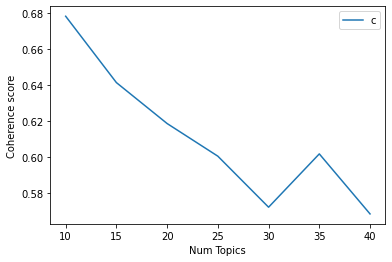

In [55]:
start=10; limit=41; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.6781
Num Topics = 15  has Coherence Value of 0.6413
Num Topics = 20  has Coherence Value of 0.6186
Num Topics = 25  has Coherence Value of 0.6005
Num Topics = 30  has Coherence Value of 0.5722
Num Topics = 35  has Coherence Value of 0.6018
Num Topics = 40  has Coherence Value of 0.5685


In [ ]:
# Select the model and print the topics
# optimal_model = model_list[4]
# optimal_model =  models.LdaModel.load('optimal_model.model')
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))